In [1]:
import os
import glob
import ast
import venn
import json
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
from dance_evaluation import *
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def load_from_pickle(filepath):
    """Load json_tempodata from a Pickle (.pkl) file."""
    # filepath = os.path.join(readpath, filename)
    with open(filepath, "rb") as f:
        json_tempodata = pickle.load(f)
    return json_tempodata

def binary_to_peak(binary_array, sampling_rate=60, peak_duration=0.05):
    """
    Represent binary array with 50ms bandwidth peaks.

    Parameters:
        binary_array (numpy.ndarray): Binary input array (1s and 0s).
        sampling_rate (int): Sampling rate in Hz.
        peak_duration (float): Duration of each peak in seconds (default is 0.05s).

    Returns:
        numpy.ndarray: Continuous signal with peaks for each 1 in the binary array.
    """
    n = len(binary_array)
    peak_samples = int(peak_duration * sampling_rate)  # Samples in 50ms
    half_peak = peak_samples // 2

    # Create a Gaussian peak
    t = np.linspace(-half_peak, half_peak, peak_samples)
    peak_shape = np.exp(-0.5 * (t / (half_peak / 2))**2)  # Gaussian

    # Create the continuous signal
    continuous_signal = np.zeros(n + peak_samples)
    for i, value in enumerate(binary_array):
        if value == 1:
            start = i
            end = i + peak_samples
            continuous_signal[start:end] += peak_shape

    # Trim to original length
    return continuous_signal[:n].reshape(-1,1)

def calculate_metrics_with_oe(ref, calculated, tol_type = "abs", tolerance=5):
    """
    Calculate Acc1, Acc2, Metric3, OE1, and OE2.
    Args:
        ref (np.ndarray): Reference BPMs.
        calculated (np.ndarray): Estimated BPMs.
        tolerance (float): Precision window (default 4%).
    Returns:
        dict: Dictionary with Acc1, Acc2, Metric3, OE1, and OE2 values.
    """
 
    if tol_type == "rel":
        ref_tolerance = ref * (tolerance/100)
    elif tol_type == "abs":
        ref_tolerance = tolerance
    
    # Acc1: Within 4% of reference BPM
    acc1_count = np.sum(np.abs(calculated - ref) <= ref_tolerance)
    
    # Acc2: Within 4% of reference BPM, double, or half
    acc2_count = np.sum(
        (np.abs(calculated - ref) <= ref_tolerance) |
        (np.abs(calculated - 2 * ref) <= ref_tolerance) |
        (np.abs(calculated - ref / 2) <= ref_tolerance)
    )
    scales = [1, 2, 0.5, 3, 1/3]
    acc3_count = np.sum(np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0))

    hits_idx = np.where(np.abs(calculated - ref) <= ref_tolerance)[0]
    hits_dbl_idx = np.where(np.abs(calculated - 2 * ref) <= ref_tolerance)[0]
    hits_hf_idx = np.where(np.abs(calculated - ref / 2) <= ref_tolerance)[0]
    
    bpm_hits_idx = calculated[hits_idx]
    bpm_hits_dbl_idx = calculated[hits_dbl_idx]
    bpm_hits_hf_idx = calculated[hits_hf_idx]
    
    # OE1: Overestimated BPM outside hierarchical relationships
    oe1_count = np.sum(
        (calculated > ref) &  # Overestimation
        ~np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Not within any scale
    )
    
    # OE2: Overestimated BPM within hierarchical relationships
    oe2_count = np.sum(
        (calculated > ref) &  # Overestimation
        np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Within any scale
    )
    
    total = len(ref)
    
    metrics = {
        "acc1": (acc1_count / total) * 100,
        "acc2": (acc2_count / total) * 100,     # double/ half
        "acc3": (acc3_count / total) * 100,     # 1x 2x 3x 0.5x 0.33x
        "OE1": (oe1_count / total) * 100,
        "OE2": (oe2_count / total) * 100,
        
        "hits_idx": hits_idx,
        "hits_dbl_idx": hits_dbl_idx,
        "hits_hf_idx": hits_hf_idx,
        
        "bpm_hits_idx": bpm_hits_idx,
        "bpm_hits_dbl_idx": bpm_hits_dbl_idx,
        "bpm_hits_hf_idx": bpm_hits_hf_idx
        
    }
    return metrics

#### Load files

In [ ]:
video_dir = "/itf-fi-ml/home/sagardu/aist_tempo_est/aist_dataset/video"
file_to_retrieve = ""


In [15]:
# def str_to_list(s):
#     s_clean = s.strip("[]")
#     return [float(item) for item in s_clean.split() if item]


# Wrist (hand) data
df_left_wrist = pd.read_pickle("./one_sensor/tempo_60_140/pos/hand/left_wrist_zero_uni_60_140.pkl")
df_right_wrist = pd.read_pickle("./one_sensor/tempo_60_140/pos/hand/right_wrist_zero_uni_60_140.pkl")

# Ankle (foot) data
df_left_ankle = pd.read_pickle("./one_sensor/tempo_60_140/pos/foot/left_ankle_zero_uni_60_140.pkl")
df_right_ankle = pd.read_pickle("./one_sensor/tempo_60_140/pos/foot/right_ankle_zero_uni_60_140.pkl")

total = df_right_wrist.shape[0]
bpm_both_hand = []
bpm_both_foot = []
bpm_all_x = []
bpm_all_y = []
bpm_both_hand_x = []
bpm_both_foot_x = []
bpm_both_hand_y = []
bpm_both_foot_y = []

for row in range(total):

    left_wrist_x = df_left_wrist.iloc[row]["estimated_bpm_per_window_x"]
    left_wrist_y = df_left_wrist.iloc[row]["estimated_bpm_per_window_y"]
    right_wrist_x = df_right_wrist.iloc[row]["estimated_bpm_per_window_x"]
    right_wrist_y = df_right_wrist.iloc[row]["estimated_bpm_per_window_y"]


    left_ankle_x = df_left_ankle.iloc[row]["estimated_bpm_per_window_x"]
    left_ankle_y = df_left_ankle.iloc[row]["estimated_bpm_per_window_y"]
    right_ankle_x = df_right_ankle.iloc[row]["estimated_bpm_per_window_x"]
    right_ankle_y = df_right_ankle.iloc[row]["estimated_bpm_per_window_y"]
    
    merged_wrist = np.column_stack((left_wrist_x, left_wrist_y, right_wrist_x, right_wrist_y))
    merged_ankle = np.column_stack((left_ankle_x, left_ankle_y, right_ankle_x, right_ankle_y))
    
    merged_all_x =  np.column_stack((left_wrist_x, right_wrist_x,
                                   left_ankle_x, right_ankle_x))   # 
    
    merged_all_y =  np.column_stack((left_wrist_y, right_wrist_y,
                                   left_ankle_y, right_ankle_y))
    
    merged_hand_x = np.column_stack((left_wrist_x, right_wrist_x))
    merged_foot_x = np.column_stack((left_ankle_x, right_ankle_x))
    
    merged_hand_y = np.column_stack((left_wrist_y, right_wrist_y,))
    merged_foot_y = np.column_stack((left_ankle_y, right_ankle_y))
    
    # both hand or foot x axis
    bpm_both_hand_x.append(np.median(merged_hand_x))
    bpm_both_foot_x.append(np.median(merged_foot_x))
    # both hand or foot y axis
    bpm_both_hand_y.append(np.median(merged_hand_y))
    bpm_both_foot_y.append(np.median(merged_foot_y))
    # both hand or foot  both axis
    bpm_both_hand.append(np.median(merged_wrist))
    bpm_both_foot.append(np.median(merged_ankle))
    # both hand both foot both axis
    bpm_all_x.append(np.median(merged_all_x))
    bpm_all_y.append(np.median(merged_all_y))

data = {
        # "filename": df_left_wrist["filename"],
        # "dance_genre": df_left_wrist["dance_genre"],
        "music_tempo": np.array(df_left_wrist["music_tempo"]),
        
        # "left_wrist": df_left_wrist["bpm_median_xy"],
        # "right_wrist": df_right_wrist["bpm_median_xy"], 
        # "left_ankle": df_left_ankle["bpm_median_xy"],
        # "right_ankle": df_right_ankle["bpm_median_xy"],
        
        "bpm_both_hand_x": np.array(bpm_both_hand_x),
        "bpm_both_hand_y": np.array(bpm_both_hand_y),
        "bpm_both_foot_x": np.array(bpm_both_foot_x),
        "bpm_both_foot_y": np.array(bpm_both_foot_y),
        
        # "bpm_both_hand": np.array(bpm_both_hand),
        # "bpm_both_foot": np.array(bpm_both_foot),
        # "bpm_all_x": np.array(bpm_all_x),
        # "bpm_all_y": np.array(bpm_all_y),
        }

data_df = pd.DataFrame(data)
data_df
    # print("\n tempo:", df_left_ankle.iloc[row]['music_tempo'])
    # print("Wrist L bpm:", df_left_wrist.iloc[row]['bpm_median_xy'])
    # print("Wrist R bpm:", df_right_wrist.iloc[row]['bpm_median_xy'])
    # print("Ankle L bpm:", df_left_ankle.iloc[row]['bpm_median_xy'])
    # print("Ankle R bpm:", df_right_ankle.iloc[row]['bpm_median_xy'])
    # print("merged_hand_bpm:", np.median(merged_wrist))
    # print("merged_foot_bpm:", np.median(merged_ankle))

# print("Ankle arrays:")
# print("left_ankle_x",left_ankle_x)
# print("left_ankle_y",left_ankle_y)
# print("right_ankle_x",right_ankle_x)
# print("right_ankle_y",right_ankle_y)

,music_tempo,bpm_both_hand_x,bpm_both_hand_y,bpm_both_foot_x,bpm_both_foot_y
0,110,110.5,110.5,106.5,112.0
1,135,94.0,116.0,102.0,99.5
2,100,80.0,102.0,110.0,103.0
3,110,107.0,106.5,86.5,96.5
4,110,86.0,70.5,110.0,83.5
...,...,...,...,...,...
1336,125,92.5,121.5,91.5,117.0
1337,130,129.5,126.5,125.5,97.5
1338,130,104.5,81.5,97.0,87.5
1339,135,104.0,117.0,101.0,101.5


In [14]:
metric ={}
for key in data.keys():

    metrics = calculate_metrics_with_oe(data["music_tempo"], data[key], tol_type = "abs", tolerance=6)
    metric[key] = metrics
    print(key ,metrics["acc1"])

music_tempo 100.0
bpm_both_hand_x 30.7979120059657
bpm_both_hand_y 49.36614466815809
bpm_both_foot_x 31.245339299030572
bpm_both_foot_y 41.23788217747949


In [10]:
# hand_hits_x = metric['bpm_both_hand_x']['hits_idx']

hand_hits_y = metric['bpm_both_hand_y']['hits_idx']
foot_hits_y = metric['bpm_both_foot_y']['hits_idx']

common = set(hand_hits_y).intersection(foot_hits_y)
hand_y_only = set(hand_hits_y) - common 
foot_y_only = set(foot_hits_y) - common
 
print("hand_hits_y:", len(hand_hits_y))
print("foot_hits_y:", len(foot_hits_y))
print("common_hits:", len(common))
print("hand_only_y_hits:", len(hand_y_only))
print("foot_only_y_hits:", len(foot_y_only))

hand_hits_y: 659
foot_hits_y: 557
common_hits: 351
hand_only_y_hits: 308
foot_only_y_hits: 206


In [6]:
from scipy.signal import find_peaks, peak_widths

def remove_low_peaks(signal, threshold_ratio=0.1, rel_height=0.5):
    """
    Remove entire narrow peaks from a 1D signal if the peak height is below
    threshold_ratio * max(signal). The region removed is defined by the peak's width
    at a relative height (default rel_height=0.5).
    
    Parameters:
        signal (array-like): 1D input signal.
        threshold_ratio (float): Fraction of the maximum value used as threshold.
        rel_height (float): Relative height at which to measure the peak width.
        
    Returns:
        np.ndarray: Signal with low peaks removed (set to zero).
    """
    signal = np.asarray(signal)
    threshold = threshold_ratio * np.max(signal)
    filtered_signal = np.copy(signal)
    
    peaks, _ = find_peaks(signal)
    widths, _, left_ips, right_ips = peak_widths(signal, peaks, rel_height=rel_height)
    
    for i, peak in enumerate(peaks):
        if signal[peak] < threshold:
            left_bound = int(np.floor(left_ips[i]))
            right_bound = int(np.ceil(right_ips[i]))
            filtered_signal[left_bound:right_bound+1] = 0
            
    return filtered_signal

def moving_average(signal, window_size):
    """
    Compute the moving average of a 1D signal using a specified window size.
    
    Parameters:
        signal (array-like): The input 1D signal.
        window_size (int): The number of samples for the moving average.
    
    Returns:
        np.ndarray: The moving average of the signal.
    """
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')



In [22]:
import shutil
video_dir = "/itf-fi-ml/home/sagardu/aist_tempo_est/aist_dataset/video"
target_dir = "/itf-fi-ml/home/sagardu/aist_tempo_est/aist_dataset"
file_to_retrieve = "gHO_sBM_c01_d20_mHO5_ch01.mp4"

file_path = os.path.join(video_dir, file_to_retrieve)
destination_path = os.path.join(target_dir, file_to_retrieve)

shutil.copyfile(file_path, destination_path)

'/itf-fi-ml/home/sagardu/aist_tempo_est/aist_dataset/gHO_sBM_c01_d20_mHO5_ch01.mp4'

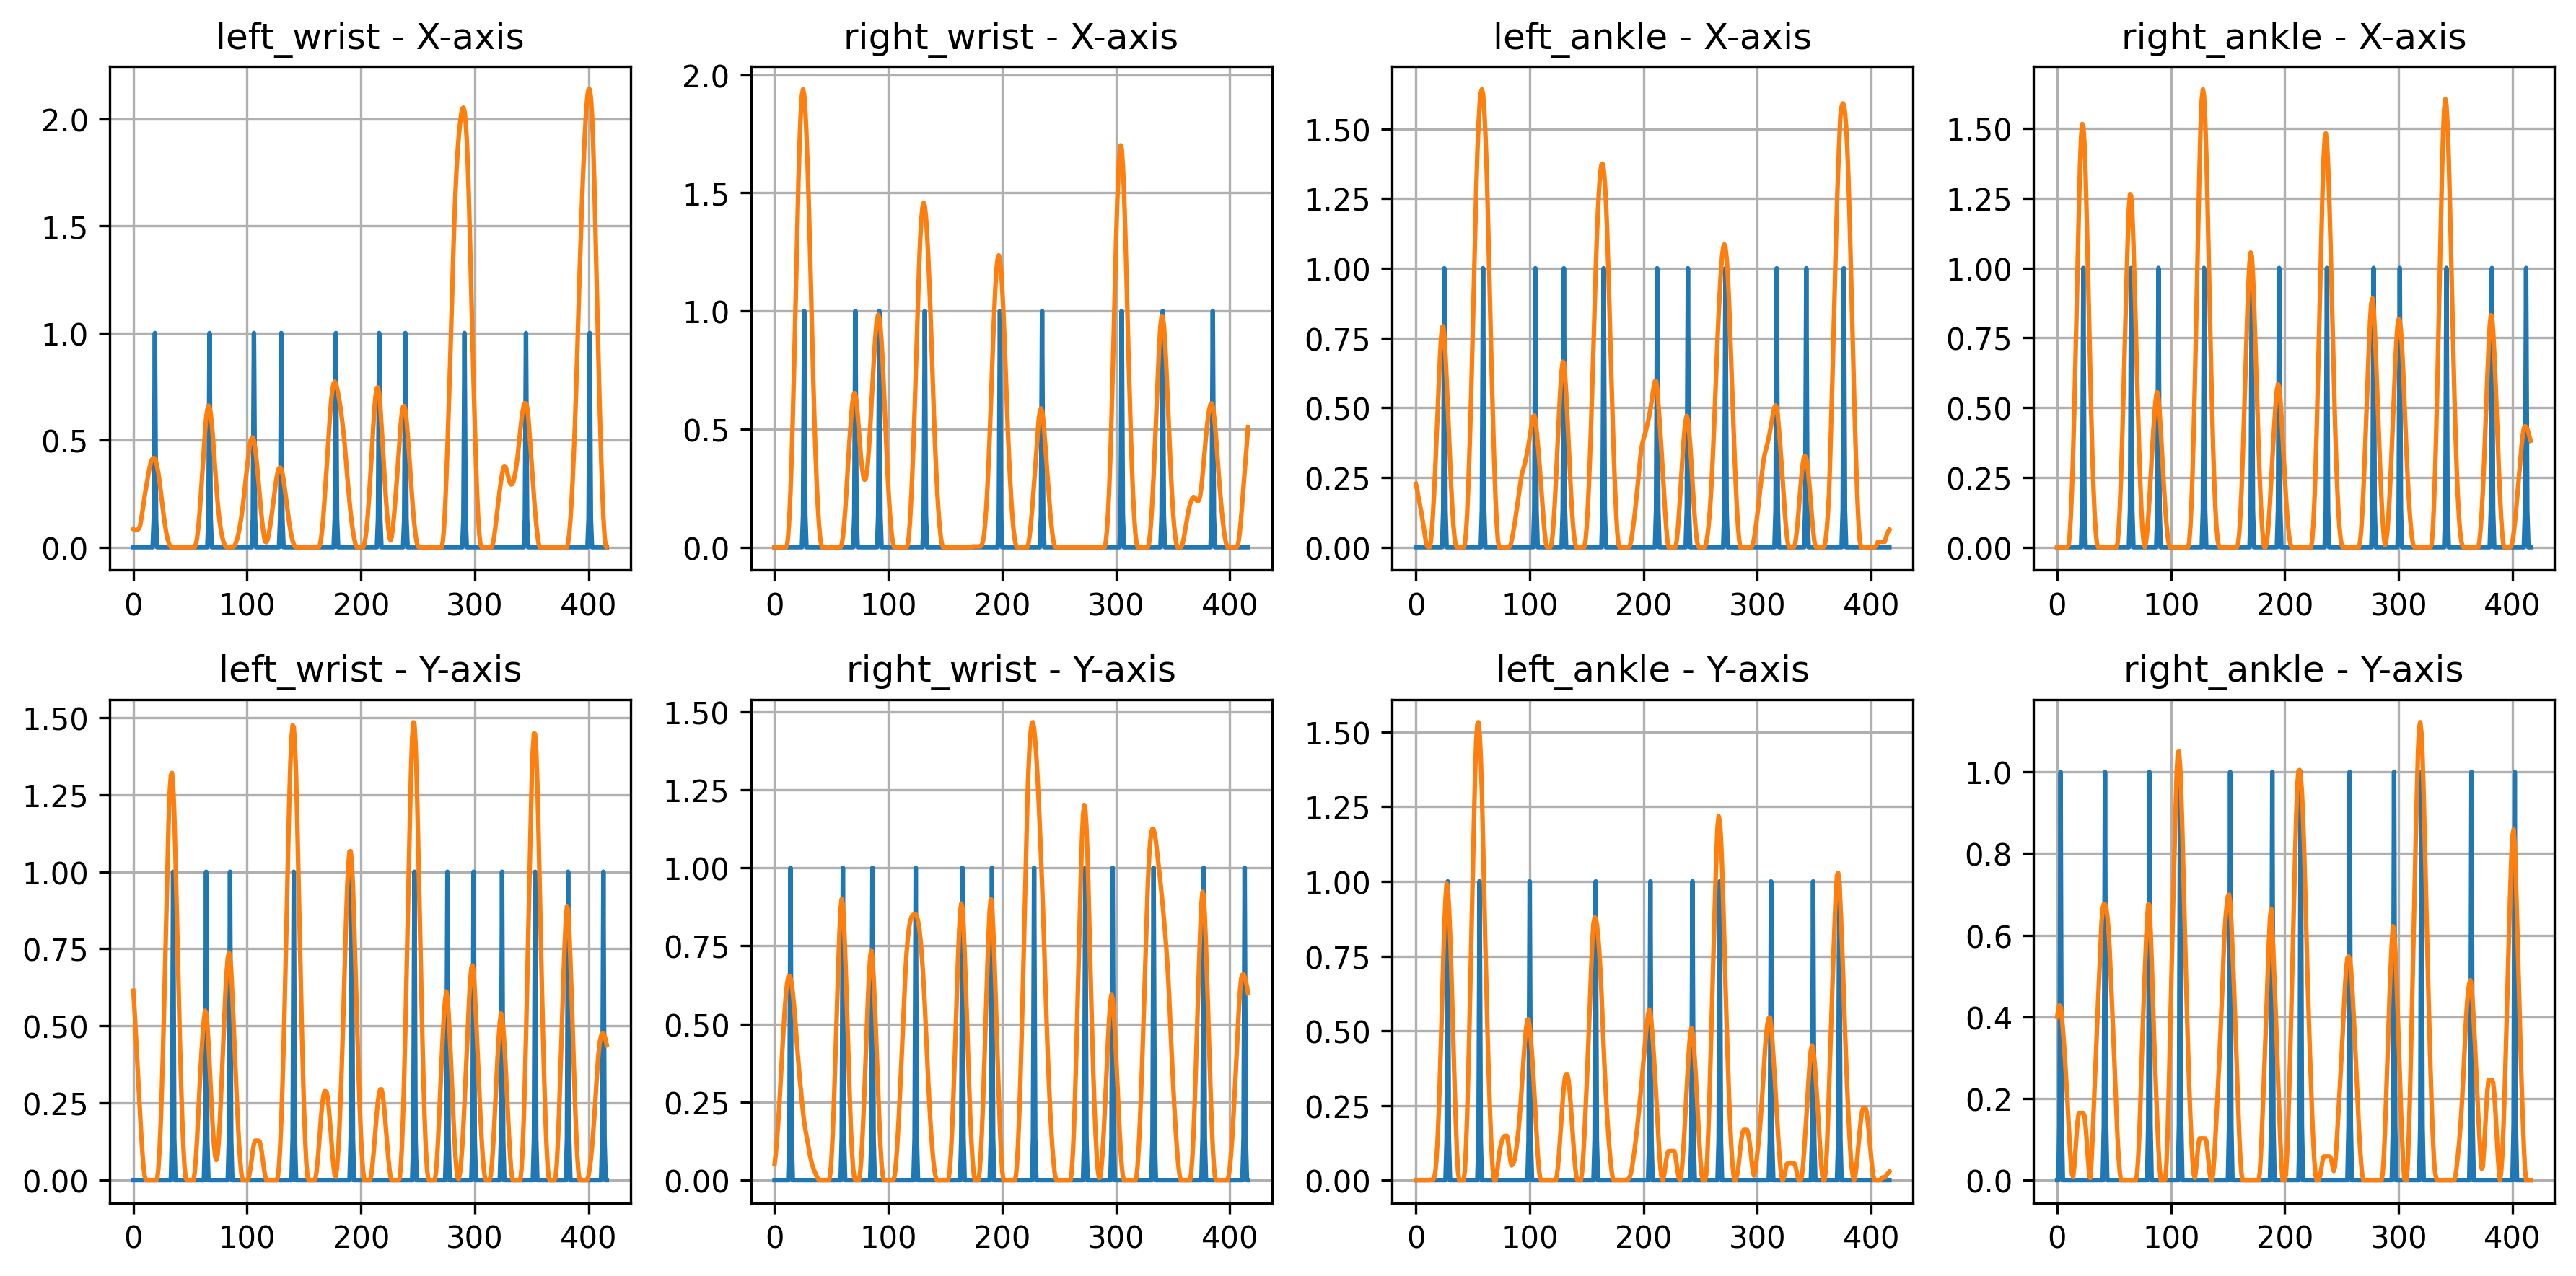

In [16]:
idx = 1
filename_suffix = df_left_wrist.iloc[idx]['filename']
file_tempo = df_left_wrist.iloc[idx]['music_tempo']

ax_label = {"ax0": "X-axis", "ax1": "Y-axis"}
sensors = ["left_wrist", "right_wrist", "left_ankle", "right_ankle", ]

# Load data for both ax0 and ax1
data_set = {"ax0": {}, "ax1": {}}
for axis in ["ax0", "ax1"]:
    base_dir = f"./one_sensor/tempo_60_140/pos/tempo_data/{axis}"
    for sensor in sensors:
        file_path = os.path.join(base_dir, f"{sensor}_zero_uni_{filename_suffix}.pkl")
        with open(file_path, "rb") as f:
            data_set[axis][sensor] = pickle.load(f)

# Create subplots: 2 rows (one per axis) and 4 columns (one per sensor)
fig, axs = plt.subplots(2, 4, figsize=(12, 6), dpi=300)  # Adjust figsize as needed

for col, sensor in enumerate(sensors):
    ax0_peak = binary_to_peak(data_set["ax0"][sensor]['sensor_onsets'], peak_duration=0.05 )
    ax1_peak = binary_to_peak(data_set["ax1"][sensor]['sensor_onsets'], peak_duration=0.05 )
    
    ax0_filtered = remove_low_peaks(data_set["ax0"][sensor]['sensor_abs'].flatten(), threshold_ratio=0.1)
    ax0_filtered = moving_average(ax0_filtered, 10)
    
    ax1_filtered = remove_low_peaks(data_set["ax1"][sensor]['sensor_abs'].flatten(), threshold_ratio=0.1)
    ax1_filtered = moving_average(ax1_filtered, 10)
    
    ax_top = axs[0, col]
    ax_top.plot(ax0_peak)
    ax_top.plot(ax0_filtered)
    ax_top.set_title(f"{sensor} - {ax_label['ax0']}")
    ax_top.grid(True)
    
    # Bottom row: plot ax1 data
    ax_bot = axs[1, col]
    ax_bot.plot(ax1_peak)
    ax_bot.plot(ax1_filtered)
    ax_bot.set_title(f"{sensor} - {ax_label['ax1']}")
    ax_bot.grid(True)

plt.tight_layout()
plt.show()


In [17]:
def autocorrelation(x):
    """Compute the normalized autocorrelation of signal x."""
    x = np.array(x) - np.mean(x)
    n = len(x)
    ac_full = np.correlate(x, x, mode='full')
    ac = ac_full[n - 1:]
    return ac / ac[0]

sampling_rate = 60  # Hz, replace with your actual sampling rate
print("Base tempo:", file_tempo)

# sensor = "left_wrist"

for sensor in sensors:
    print(sensor)
    # Process ax0 data
    sensor_signal_ax0 = ax0_filtered
    ac_ax0 = autocorrelation(sensor_signal_ax0.flatten())
    peaks_ax0, _ = find_peaks(ac_ax0[1:])  # Skip zero lag
    if len(peaks_ax0) > 0:
        estimated_lag_ax0 = peaks_ax0[0] + 1
        beat_period_seconds_ax0 = estimated_lag_ax0 / sampling_rate
        tempo_ax0 = round(60 / beat_period_seconds_ax0)
        print("x-axis: Estimated tempo (bpm):", tempo_ax0)
    else:
        print("x-axis: No significant peak found in the autocorrelation function.")

    # Process ax1 data
    sensor_signal_ax1 = ax1_filtered
    ac_ax1 = autocorrelation(sensor_signal_ax1.flatten())
    peaks_ax1, _ = find_peaks(ac_ax1[1:])  # Skip zero lag
    if len(peaks_ax1) > 0:
        estimated_lag_ax1 = peaks_ax1[0] + 1
        beat_period_seconds_ax1 = estimated_lag_ax1 / sampling_rate
        tempo_ax1 = round(60 / beat_period_seconds_ax1)
        print("y-axis: Estimated tempo (bpm):", tempo_ax1)
    else:
        print("y-axis: No significant peak found in the autocorrelation function.")

# Plot autocorrelation functions for ax0 and ax1
# fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# axs[0].plot(ac_ax0, label="ax0 Autocorrelation")
# axs[0].set_title(f"Autocorrelation of {sensor} 'sensor_abs' (ax0)")
# axs[0].set_xlabel("Lag (samples)")
# axs[0].set_ylabel("Normalized Autocorrelation")
# axs[0].grid(True)
# axs[0].legend()

# axs[1].plot(ac_ax1, label="ax1 Autocorrelation")
# axs[1].set_title(f"Autocorrelation of {sensor} 'sensor_abs' (ax1)")
# axs[1].set_xlabel("Lag (samples)")
# axs[1].set_ylabel("Normalized Autocorrelation")
# axs[1].grid(True)
# axs[1].legend()

# plt.tight_layout()
# plt.show()


Base tempo: 135
left_wrist
x-axis: Estimated tempo (bpm): 88
y-axis: Estimated tempo (bpm): 90
right_wrist
x-axis: Estimated tempo (bpm): 88
y-axis: Estimated tempo (bpm): 90
left_ankle
x-axis: Estimated tempo (bpm): 88
y-axis: Estimated tempo (bpm): 90
right_ankle
x-axis: Estimated tempo (bpm): 88
y-axis: Estimated tempo (bpm): 90


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def comb_filter(ac, period):
    """
    Apply a comb filter with a given period on the autocorrelation signal.
    
    Parameters:
        ac (np.array): Autocorrelation signal.
        period (int): Candidate beat period (in samples).
        
    Returns:
        float: The summed response of the comb filter.
    """
    kernel = np.zeros_like(ac)
    indices = np.arange(0, len(ac), period)
    kernel[indices] = 1
    response = np.sum(ac * kernel)
    return response

def find_tempo_via_comb_filter(ac, min_period, max_period, sampling_rate):
    """
    Test a range of candidate periods using a comb filter on the autocorrelation signal,
    and select the candidate with the highest response to estimate tempo.
    
    Parameters:
        ac (np.array): Autocorrelation signal.
        min_period (int): Minimum candidate period (in samples).
        max_period (int): Maximum candidate period (in samples).
        sampling_rate (float): Sampling rate in Hz.
        
    Returns:
        best_period (int): Best candidate period (in samples).
        tempo_bpm (float): Estimated tempo in beats per minute.
        candidate_periods (np.array): Array of candidate periods tested.
        responses (np.array): Comb filter responses for each candidate.
    """
    candidate_periods = np.arange(min_period, max_period + 1)
    responses = np.array([comb_filter(ac, period) for period in candidate_periods])
    
    best_idx = np.argmax(responses)
    best_period = candidate_periods[best_idx]
    tempo_bpm = 60 * sampling_rate / best_period
    return best_period, tempo_bpm, candidate_periods, responses

# Example usage:
# Assuming 'ac' is your autocorrelation output signal from sensor data.
# For instance, if using data_set["ax0"][sensor]['sensor_abs'], first compute ac:
# sensor_signal = data_set["ax0"][sensor]['sensor_abs']
# ac = autocorrelation(sensor_signal.flatten())

sampling_rate = 60  # in Hz (adjust as needed)
min_period = 20     # minimum candidate period in samples
max_period = 300    # maximum candidate period in samples

best_period, tempo_bpm, candidate_periods, responses = find_tempo_via_comb_filter(ac_ax0, min_period, max_period, sampling_rate)
print("Best period (samples):", best_period)
print("Estimated Tempo (bpm):", tempo_bpm)

# Plot the comb filter responses over candidate periods
plt.figure(figsize=(8, 4))
plt.plot(candidate_periods, responses, label="Comb Filter Response")
plt.xlabel("Candidate Period (samples)")
plt.ylabel("Response")
plt.title("Comb Filter Response vs. Candidate Period")
plt.grid(True)
plt.legend()
plt.show()
